### Libraries

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.applications import EfficientNetB7
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, 
    DepthwiseConv2D, GlobalAveragePooling2D, Reshape, Activation, Multiply, 
    Input, Add, LSTM, GRU
)

from keras import regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

### Settings

In [2]:
### ---------------- Paths ---------------- ###

# IP102 path
ip_102_path = "../../../Data/MSiA 432/03_hw/IP102-Dataset/"

# FairFace path
fair_face_path = "../../../Data/MSiA 432/03_hw/FairFace/"

### ---------------- GPU(s) ---------------- ###

# Select GPU(s)
gpus = (0,) # Example: Set as (0, 1, 3) to use 1st, 2nd, and 4th GPUs - Currently (0,) because I have 1 GPU

# Function to set which GPUs are visible to TensorFlow
def set_gpus(*gpu_indices):
    # Get list of GPUs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))

    if gpus:
        visible_gpus = [gpus[i] for i in gpu_indices]
        try:
            # Only use specified GPUs and ignore the others
            tf.config.experimental.set_visible_devices(visible_gpus, 'GPU')
            for gpu in visible_gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Using GPUs: ", [gpu.name for gpu in visible_gpus])
        except RuntimeError as e:
            print(e)
    return visible_gpus

# Call the function with the indices of the GPUs you want to use
visible_gpus = set_gpus(*gpus)  # Use the second, third, fourth, and fifth GPU

# Extract names of the GPUs being used
gpu_names = ['/device:GPU:' + gpu.name.split(':')[-1] for gpu in visible_gpus]
print(gpu_names)

Num GPUs Available:  1
Using GPUs:  ['/physical_device:GPU:0']
['/device:GPU:0']


# Question 1

In word document attatched with this submission

# Question 2

## a. Data Preprocessing

### Get file locations

In [3]:
# Define the column names for the DataFrame
columns = ["img_path", "target"]

# Read the training, validation and test data from text files into respective DataFrames
train_df = pd.read_csv(ip_102_path + "train.txt", header=None, sep=" ", names=columns)
val_df = pd.read_csv(ip_102_path + "val.txt", header=None, sep=" ", names=columns)
test_df = pd.read_csv(ip_102_path + "test.txt", header=None, sep=" ", names=columns)

# Preprocess each DataFrame (train_df, val_df, test_df) 
for df in [train_df, val_df, test_df]:
    # Convert the 'target' column to string type, to handle it as categorical data
    df.target = df.target.astype(str)
    
    # Update 'img_path' column to include 'target' as subfolder, for accessing the image files
    df['img_path'] = df['target'].astype(str) + '/' + df['img_path']

# Get the number of unique target classes in the training data, to know the dimensionality of the classification problem
num_classes = len(train_df.target.unique())

# Print the first few rows of the training DataFrame, to check its structure
train_df.head()

,img_path,target
0,0/00002.jpg,0
1,0/00003.jpg,0
2,0/00005.jpg,0
3,0/00006.jpg,0
4,0/00008.jpg,0


### Plot Distribution of Classes

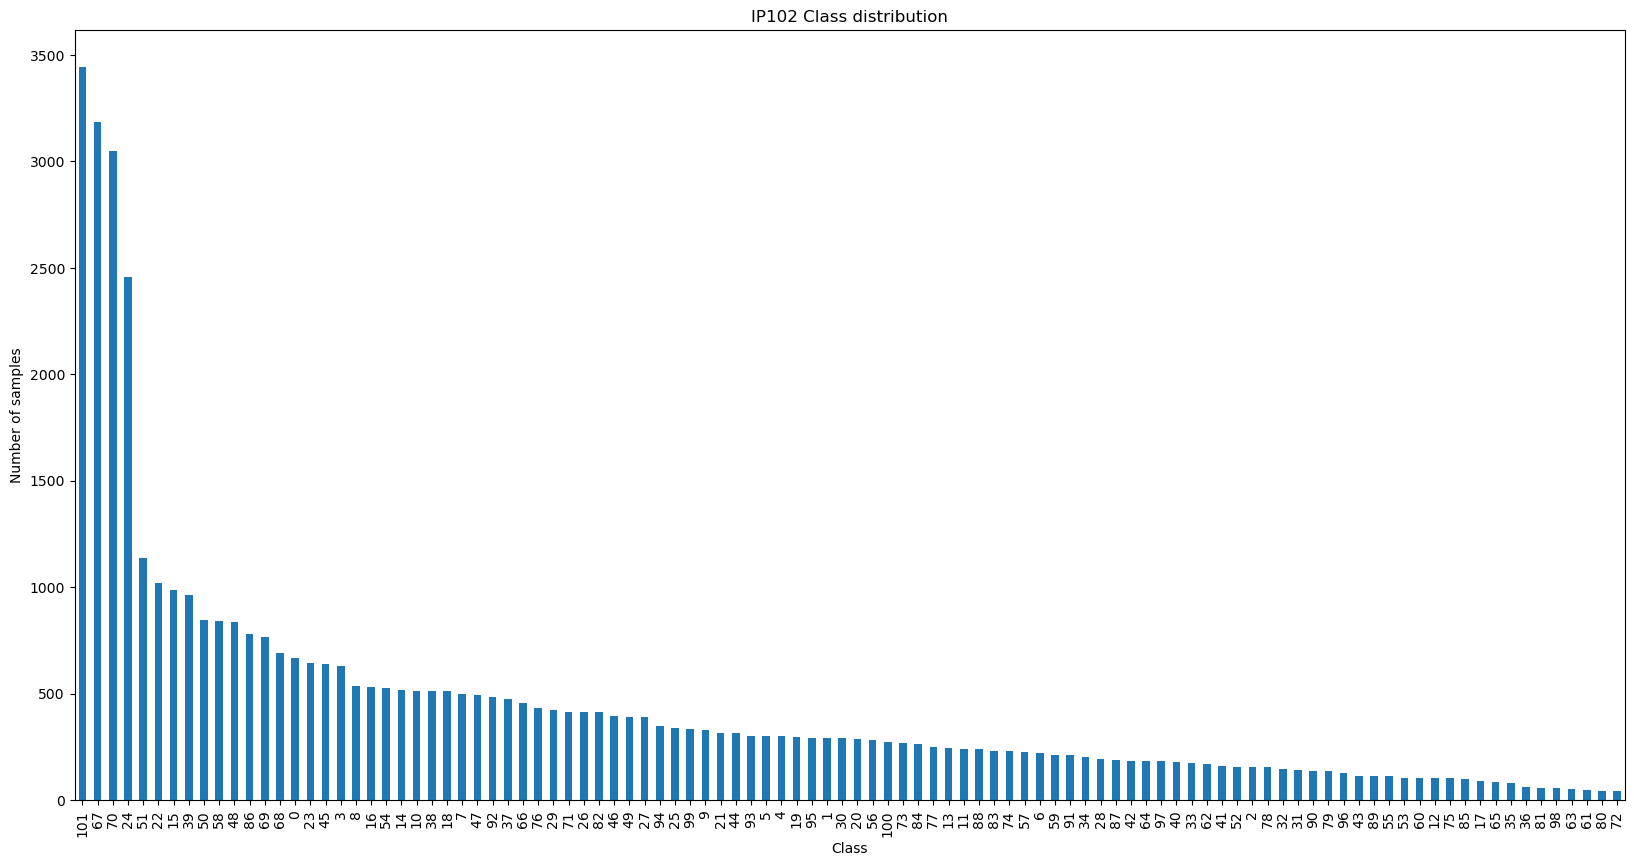

In [4]:
# Calculate the frequency of each class in the target column of the training set, to understand class distribution
class_counts = train_df['target'].value_counts()

# Plot class distribution for visualization
plt.figure(figsize=(20, 10))
class_counts.plot(kind='bar')
plt.title('IP102 Class distribution')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

### Prepare Images for CNN

In [5]:
# Define ImageDataGenerator for training (with data augmentation) to improve model generalization
train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values to [0,1]
        rotation_range=20,  # Randomly apply rotations
        zoom_range=0.05,  # Randomly apply zoom
        width_shift_range=0.05,  # Randomly shift images horizontally
        height_shift_range=0.05,  # Randomly shift images vertically
        shear_range=0.05,  # Randomly apply shear transformations
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode="nearest")  # Set strategy for filling in newly created pixels

# Define ImageDataGenerator for validation and testing (without augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0,1]

In [6]:
# Set the batch size for the generators
batch_size = 32

# Create data generators for training, validation and testing
# These will be used to supply data to the model during training/validation/testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(ip_102_path, "classification/train"),
    x_col="img_path",
    y_col="target",
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=os.path.join(ip_102_path, "classification/val"),
    x_col="img_path",
    y_col="target",
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(ip_102_path, "classification/test"),
    x_col="img_path",
    y_col="target",
    target_size=(100, 100),
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

Found 45095 validated image filenames belonging to 102 classes.
Found 7508 validated image filenames belonging to 102 classes.
Found 22619 validated image filenames belonging to 102 classes.


## b. Custom Model

### Hyperparameters

In [7]:
# Training paramaters
input_shape = (100, 100, 3)
optimizer = "adam"
loss = "categorical_crossentropy"
metrics = ["accuracy"]
epochs = 3
regs = (0.00001, 0.00001)

### Hyperparameter and Layer Reasoning:

1. **Optimizer**: Adam was chosen as the optimizer for this model due to its adaptive learning rate properties. By individually adapting the learning rates, Adam often leads to better performance in comparison to other optimizers such as SGD.

2. **Loss function**: The categorical cross-entropy loss was used for this model as it is typically suitable for multi-class classification problems. This function compares the model's prediction probabilities with the true label, making it suitable for training models to predict probabilities in a multi-class setting.

3. **Metrics**: Accuracy was chosen as the evaluation metric because this model is designed for multi-class classification. Accuracy is a common and straightforward metric for this kind of task.

4. **Number of filters and filter size in Conv2D**: The model starts with 32 filters and doubles to 64 filters in the second Conv2D layer. This design is based on the common practice of increasing the model's capacity while moving deeper into the network. The filter size of (3,3) was chosen as it is a standard choice that balances computational efficiency and the ability to learn spatial hierarchies.

5. **Pool size in MaxPooling2D**: A pool size of (2,2) is used to reduce the spatial dimensions of the input. This can reduce the amount of computation needed, as well as making the learned representations more robust to small translations in the input image.

6. **Dropout rates**: Dropout rates of 0.25 and 0.5 were selected to prevent overfitting. The higher dropout rate is used in the fully connected layer, which often contains more parameters and hence requires more regularization.

7. **Number of nodes in the first Dense layer**: A size of 512 was chosen for the first dense layer. This choice offers a balance between computational efficiency and the model's capacity to learn from the data. Depending on the complexity of the problem and the size of the dataset, this number can be adjusted to achieve better performance.

8. **Activation functions**: The ReLU activation function was chosen for the hidden layers because it can mitigate the vanishing gradient problem during backpropagation. On the other hand, the softmax activation was used in the output layer to output a valid probability distribution for the predicted classes.

9. **Regularizers in Conv2D**: L1 and L2 regularizers are applied to the convolutional layers, this helps in penalizing large weights and thus, reduces overfitting. The regularization rates regs[0] and regs[1] can be tuned based on the amount of overfitting observed in the model's performance. Regularization helps in keeping the model weights small, thereby improving the model's generalization capabilities.

### Create and Fit CNN

In [8]:
# Create a MirroredStrategy for distributed training across multiple GPUs
strategy = tf.distribute.MirroredStrategy(devices=gpu_names)

def create_model(input_shape, num_classes, regs):

    model = Sequential([

        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1_l2(l1=regs[0], l2=regs[1])),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax'),

    ])

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

# Open the strategy scope
with strategy.scope():
    model = create_model(input_shape, num_classes, regs)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


### Model Architecture Summary:

This Convolutional Neural Network (CNN) model follows a classic structure of stacking convolutional layers followed by max pooling and dropout for the purpose of feature extraction, ending with a flatten layer, dense layers, and a final classification layer. The model utilizes TensorFlow's Keras API, making it clear and easily reproducible.

1. **Conv2D Layers**: The model begins with two sets of Conv2D layers. The first set uses 32 filters of 3x3 size, a ReLU activation function, and L1 and L2 regularization. The second set consists of two additional Conv2D layers with 64 filters, again of 3x3 size, and ReLU activation. These layers are designed to extract important features from the input data.

2. **MaxPooling2D Layers**: Each set of Conv2D layers is followed by a MaxPooling2D layer with a pool size of 2x2, effectively downsampling the input by taking the maximum value over the window defined by pool size for each dimension along the features axis.

3. **Dropout Layers**: Following the MaxPooling2D layers are Dropout layers with dropout rates of 0.25, respectively, randomly setting a fraction of input units to 0 at each update during training time, which helps prevent overfitting.

4. **Flatten Layer**: The model includes a Flatten layer, which converts the 2D matrix data to a vector. This layer does not affect the batch size.

5. **Dense Layers**: After the Flatten layer, the model has a Dense layer with 512 nodes using a ReLU activation function. This is followed by another Dropout layer, this time with a rate of 0.5, and then another Dense layer, the size of which is determined by the number of classes in the dataset.

6. **Output Layer**: The output layer is a Dense layer with a number of nodes equal to the number of classes. This layer uses a softmax activation function, making it suitable for multiclass classification tasks.


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 64)        36928     
                                                        

### Number of Parameters in Each Layer:

Each layer in the model contributes a number of trainable parameters. Here's the breakdown for each layer:

1. **First Conv2D layer**:
    - Number of filters: 32
    - Each filter size: 3x3
    - Input depth (channels): 3 (assuming RGB images)
    - Parameters per filter: 3 * 3 * 3 = 27 (weights) + 1 (bias)
    - Total parameters: 32 * (27 + 1) = 896
</br></br>
2. **Second Conv2D layer**:
    - Number of filters: 32
    - Each filter size: 3x3
    - Input depth (channels): 32 (output from previous layer)
    - Parameters per filter: 3 * 3 * 32 = 288 (weights) + 1 (bias)
    - Total parameters: 32 * (288 + 1) = 9248
</br></br>
3. **MaxPooling2D and Dropout layers**:
    - These layers don't have trainable parameters.
</br></br>
4. **Third Conv2D layer**:
    - Number of filters: 64
    - Each filter size: 3x3
    - Input depth (channels): 32 (output from previous Conv2D layer)
    - Parameters per filter: 3 * 3 * 32 = 288 (weights) + 1 (bias)
    - Total parameters: 64 * (288 + 1) = 18496
</br></br>
5. **Fourth Conv2D layer**:
    - Number of filters: 64
    - Each filter size: 3x3
    - Input depth (channels): 64 (output from previous layer)
    - Parameters per filter: 3 * 3 * 64 = 576 (weights) + 1 (bias)
    - Total parameters: 64 * (576 + 1) = 36928
</br></br>
6. **Flatten layer**:
    - The output of the previous layer is flattened. This layer doesn't introduce any new parameters.
</br></br>
7. **First Dense (fully-connected) layer**:
    - The input size will depend on the dimensions of the image after all the pooling operations and the number of filters in the last Conv2D layer. In our case, the size of each feature map after the final MaxPooling2D layer is (23, 23, 64). Therefore, the total size, denoted by 'd', is 23 * 23 * 64 = 33856.
    - Number of weights = d * 512 = 33856 * 512 = 17334272
    - Number of biases = 512
    - Total parameters = (d * 512) + 512 = 17334272 + 512 = 17334784
</br></br>
8. **Second Dense (fully-connected) layer**:
    - This is the output layer of the network. The input to this layer is the output of the previous Dense layer, which has 512 neurons.
    - Number of weights = 512 * 102
    - Number of biases = 102
    - Total parameters = (512 * 102) + 102 = 52326
</br></br>
### Total Model Parameters

The total number of trainable parameters in the model is the sum of the parameters in each layer:

896 (First Conv2D layer) + 9248 (Second Conv2D layer) + 18496 (Third Conv2D layer) + 36928 (Fourth Conv2D layer) + 17334784 (First Dense layer) + 52326 (Second Dense layer) = **17,452,678**.


In [10]:
# Train CNN from scratch
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    verbose = 1
)

Epoch 1/3
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
1409/1409 - 235s - loss: 3.9918 - accuracy: 0.1137 - val_loss: 3.7535 - val_accuracy: 0.1453 - 235s/epoch - 167ms/step
Epoch 2/3
1409/1409 - 221s - lo

### Plot Training and Validation Loss

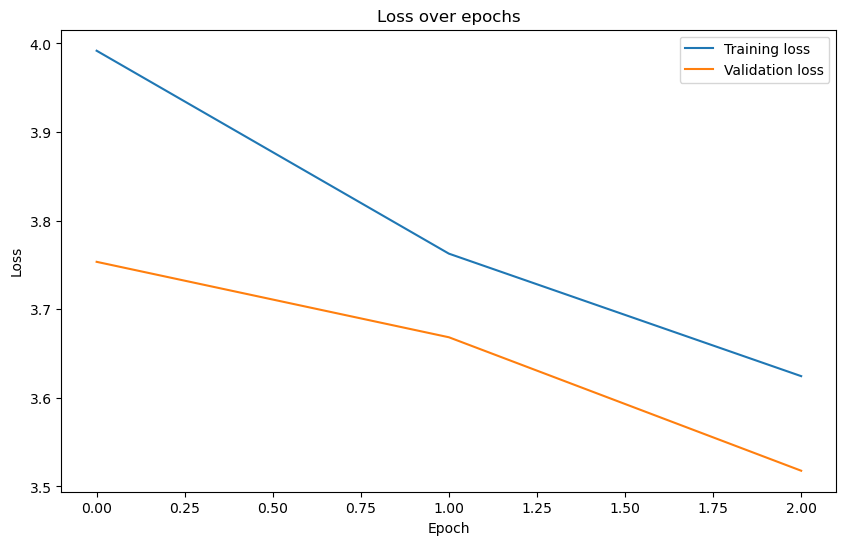

In [11]:
# Plotting the Training and Validation Loss Over Epochs
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## c. Transfer Learning

### Get EfficientNetB7 and Freeze Top Layers

In [12]:
# Function to apply transfer learning to a base model
def apply_transfer_learning(base_model, input_shape, num_classes, optimizer, loss, metrics):
    base_model.trainable = False  # Freeze layers

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())  # Flatten the output of the base model
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

### Prepare Frozen EfficientNetB7

In [13]:
# Create an instance of EfficientNetB7 with pre-trained weights for transfer learning
efficientnet_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

# Apply transfer learning to the base model
efficientnet_tl_model = apply_transfer_learning(efficientnet_model, input_shape, num_classes, optimizer, loss, metrics)

### Transfer EfficientNetB7

In [14]:
# Train EfficientNetB7 transfer learning model
history_efficientnet = efficientnet_tl_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    verbose = 1
)

Epoch 1/3
1409/1409 [==============================] - 269s 176ms/step - loss: 54.2405 - accuracy: 0.0280 - val_loss: 52.9742 - val_accuracy: 0.0698
Epoch 2/3
1409/1409 [==============================] - 243s 172ms/step - loss: 54.0306 - accuracy: 0.0292 - val_loss: 58.3151 - val_accuracy: 0.0100
Epoch 3/3
1409/1409 [==============================] - 247s 175ms/step - loss: 53.2751 - accuracy: 0.0285 - val_loss: 64.8957 - val_accuracy: 0.0219


### Evaluate and Compare EfficientNetB7 to Custom Model

In [19]:
# Evaluate both models on the test set
custom_model_metrics = model.evaluate(
    test_generator,
    verbose = 1
    )
tl_model_metrics = efficientnet_tl_model.evaluate(
    test_generator,
    verbose = 1
    )

22619/22619 [==============================] - 1193s 53ms/step - loss: 64.9940 - accuracy: 0.0223


In [20]:
# Print out the evaluation results for both models
print(f'Custom Model: Loss = {custom_model_metrics[0]}, Accuracy = {custom_model_metrics[1]}')
print(f'Transfer Learning Model: Loss = {tl_model_metrics[0]}, Accuracy = {tl_model_metrics[1]}')

Custom Model: Loss = 3.5155227184295654, Accuracy = 0.1818382740020752
Transfer Learning Model: Loss = 64.99398040771484, Accuracy = 0.022282151505351067


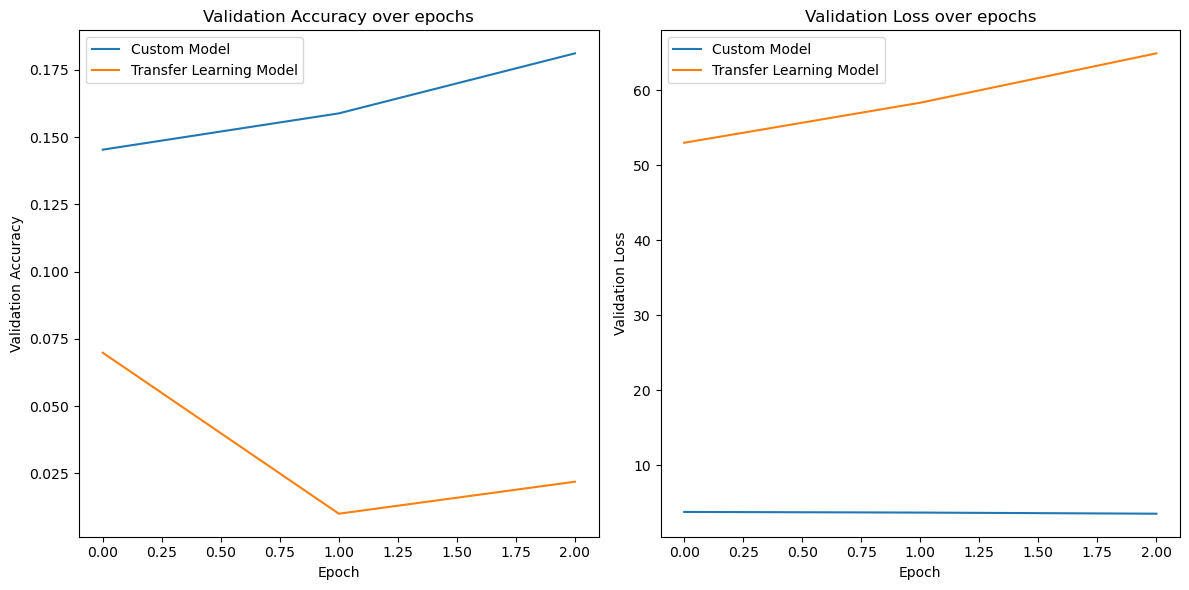

In [24]:
# Plot validation accuracy and loss for both models
plt.figure(figsize=(12,6))

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Custom Model')
plt.plot(history_efficientnet.history['val_accuracy'], label='Transfer Learning Model')
plt.title('Validation Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Custom Model')
plt.plot(history_efficientnet.history['val_loss'], label='Transfer Learning Model')
plt.title('Validation Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Question 3

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                32        
                                                                 
 dense_7 (Dense)             (None, 32)                544       
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________

----------------------------------


----------------------------------



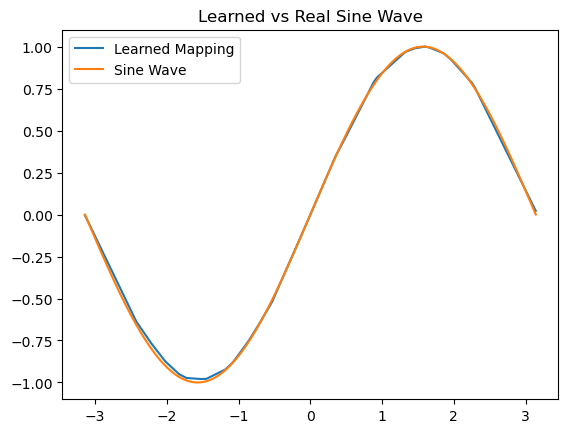

In [28]:
# Prepare the dataset
X = np.linspace(-np.pi, np.pi, 1000)
Y = np.sin(X)

# Build the model using Keras
model = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Summarize the model architecture
model.summary()
print("\n----------------------------------\n")

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mse')

# Train the model
model.fit(X, Y, epochs=10, batch_size=32, verbose=0)
print("\n----------------------------------\n")

# Test the model
test_input = np.linspace(-np.pi, np.pi, 1000)
test_output = model.predict(test_input, verbose=0)

# Plot the learned mapping and compare it with the sine wave
plt.plot(test_input, test_output, label='Learned Mapping')
plt.plot(test_input, np.sin(test_input), label='Sine Wave')
plt.title("Learned vs Real Sine Wave")
plt.legend()
plt.show()

In [ ]:
# Build the LSTM model
lstm_model = Sequential([
    LSTM(16, activation='tanh', input_shape=(1,1), return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(1)
])

# Summarize the model architecture
lstm_model.summary()

# Compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

# Reshape the data to 3D for LSTM
X_reshaped = X.reshape(-1, 1, 1)
Y_reshaped = Y.reshape(-1, 1)

# Train the model
lstm_model.fit(X_reshaped, Y_reshaped, epochs=10, batch_size=32)

# Test the model
test_input_reshaped = test_input.reshape(-1, 1, 1)
test_output_lstm = lstm_model.predict(test_input_reshaped)

# Plot the learned mapping and compare it with the sine wave
plt.plot(test_input, test_output_lstm, label='Learned Mapping - LSTM')
plt.plot(test_input, np.sin(test_input), label='Sine Wave')
plt.title("Learned vs Real Sine Wave - LSTM")
plt.legend()
plt.show()

In [ ]:
# Build the GRU model
gru_model = Sequential([
    GRU(16, activation='tanh', input_shape=(1,1), return_sequences=True),
    GRU(32, activation='tanh'),
    Dense(1)
])

# Summarize the model architecture
gru_model.summary()

# Compile the model
gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

# Train the model
gru_model.fit(X_reshaped, Y_reshaped, epochs=10, batch_size=32)

# Test the model
test_output_gru = gru_model.predict(test_input_reshaped)

# Plot the learned mapping and compare it with the sine wave
plt.plot(test_input, test_output_gru, label='Learned Mapping - GRU')
plt.plot(test_input, np.sin(test_input), label='Sine Wave')
plt.title("Learned vs Real Sine Wave - GRU")
plt.legend()
plt.show()

# Question 4

In [ ]:


# Load the CSV data
train_df = pd.read_csv(fair_face_path + "train_labels.csv")
val_df = pd.read_csv(fair_face_path + "val_labels.csv")

# Label encoding for race column
le = LabelEncoder()
train_df['race'] = le.fit_transform(train_df['race'])
val_df['race'] = le.transform(val_df['race'])

# Create an ImageDataGenerator object for the training and validation datasets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(train_df, directory=fair_face_path + "train/",
                                                    x_col="file", y_col="race", target_size=(224, 224),
                                                    class_mode='categorical', batch_size=32)

val_generator = val_datagen.flow_from_dataframe(val_df, directory=fair_face_path + "val/",
                                                x_col="file", y_col="race", target_size=(224, 224),
                                                class_mode='categorical', batch_size=32)


In [ ]:
from keras.applications import ResNet50

# Load the pre-trained ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, validation_data=val_generator, epochs=10)

In [ ]:
# Make predictions on the validation data
val_generator.shuffle = False
val_predictions = model.predict(val_generator)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Calculate accuracy and F1 score
accuracy = accuracy_score(val_generator.classes, val_predicted_classes)
f1 = f1_score(val_generator.classes, val_predicted_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")